In [40]:
import anndata as ad
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

In [41]:
%run -i 0_functions.py

In [42]:
from dynchro.tl import traceback_yedge, traceback_xedge, traceback

In [43]:
id_name = {}

counter = 0
division = 5
for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "mono"}
        # print(counter)
        counter += 1

for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "ery"}
        # print(counter)
        counter += 1

In [44]:
results_all_subsets = pickle.load(open("data/results_dynchro_hvg_subsets_no_dup.pkl", "rb"))

# Bad alignment

In [45]:
d1_id = 10
d2_id = 23

In [46]:
res1 = results_all_subsets[d1_id][d2_id][0]
res1.plot_cost_distances()

start with results_all_subsets 10, 23

In [47]:
dataset1 = read_with_pc(f"data/rep{id_name[d1_id]['rep']}_{id_name[d1_id]['cell_type']}_subset{id_name[d1_id]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[d2_id]['rep']}_{id_name[d2_id]['cell_type']}_subset{id_name[d2_id]['subset']}_hvg.h5ad")

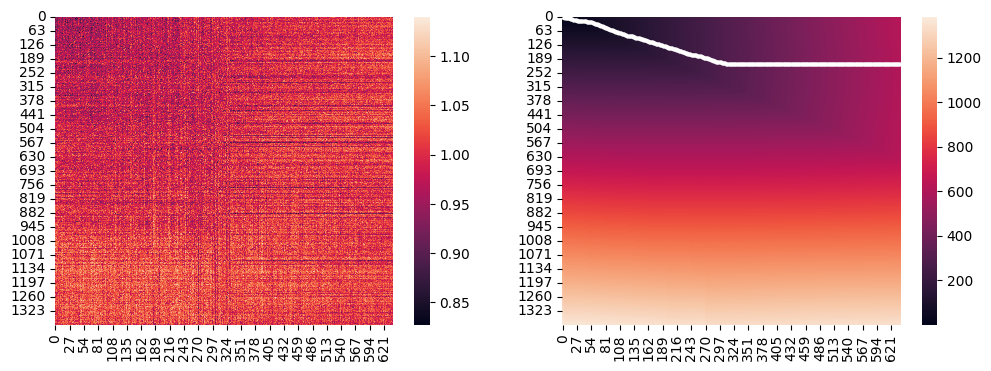

In [48]:
path2, path1 = traceback_yedge(res1.distances())
plot_cost_distances(res1.cost(), res1.distances(), path2, path1)

### investigate avg cost path

In [100]:
def plot_cost_distances(cost, distances, path1, path2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    sns.heatmap(cost, ax=ax1)
    distances = distances
    sns.heatmap(distances, ax=ax2)
    plt.scatter(path2, path1, c="white", s=30)
    plt.show()

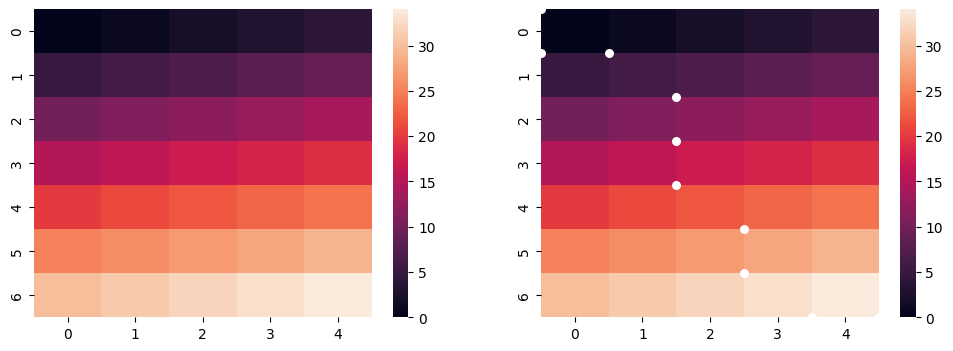

['d1_cell0', 'd1_cell1', 'd1_cell2', 'd1_cell3', 'd1_cell4'] ['d2_cell0', 'd2_cell1', 'd2_cell2', 'd2_cell3', 'd2_cell4', 'd2_cell5', 'd2_cell6']


In [101]:
# matrix from 0 to 35, 5x7
mtx = np.arange(35).reshape(7, 5)
mtx
# path1 is y coordinates
path1 = [0, 1, 1, 2, 3, 4, 5, 6, 7, 7]
path2 = [0, 0, 1, 2, 2, 2, 3, 3, 4, 5]
plot_cost_distances(mtx, mtx, path1, path2)

d1_names = [f"d1_cell{i}" for i in range(mtx.shape[1])]
d2_names = [f"d2_cell{i}" for i in range(mtx.shape[0])]
print(d1_names, d2_names)

In [102]:
max(path1), max(path2), len(d1_names), len(d2_names), mtx.shape

(7, 5, 5, 7, (7, 5))

### continue

In [49]:
# pathx must be the path that represents the x values of the path. 
#       it also indexes datasetx, so they must be the same length or less
# pathy must be the path that represents the y values of the path.
#       it also indexes datasety, so they must be the same length or less
def avg_cost_path(pathx, pathy, matrix, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index
    print(max(pathx), max(pathy), len(sorted_names1), len(sorted_names2), matrix.shape)

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_costx = defaultdict(list)
    avg_costy = defaultdict(list)

    for x, y in zip(pathx, pathy):
        # print(x, y)
        cost = matrix[y-1, x-1]

        avg_costx[sorted_names1[x-1]].append(cost)
        avg_costy[sorted_names2[y-1]].append(cost)

    acx = [sum(x) / len(x) for x in avg_costx.values()]
    acy = [sum(x) / len(x) for x in avg_costy.values()]

    costx = pd.Series(acx, index=list(avg_costx.keys()))
    costy = pd.Series(acy, index=list(avg_costy.keys()))

    return costx, costy

In [50]:
max(path1), max(path2), len(dataset1.obs_names), len(dataset2.obs_names), res1.cost().shape

(np.int64(639), np.int64(215), 1386, 640, (1385, 639))

In [51]:
costx, costy = avg_cost_path(pathx=path2, pathy=path1, matrix=res1.cost(), datasetx=dataset1, datasety=dataset2)
distx, disty = avg_cost_path(pathx=path2, pathy=path1, matrix=res1.distances()[1:, 1:], datasetx=dataset1, datasety=dataset2)

215 639 1386 640 (1385, 639)
215 639 1386 640 (1385, 639)


In [52]:
dataset1.obs["avg_cost_free"] = costx
dataset2.obs["avg_cost_free"] = costy
dataset1.obs["avg_dist_free"] = distx
dataset2.obs["avg_dist_free"] = disty

In [53]:
sc.pl.tsne(dataset1, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")
sc.pl.tsne(dataset2, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")

In [54]:
result = dynchro_wrapper(dataset1, dataset2)

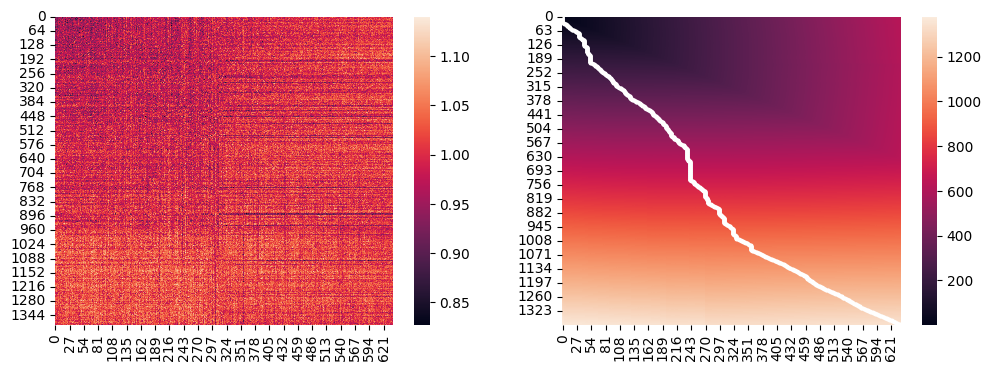

In [55]:
result[0].plot_cost_distances()

In [56]:
res1.distances().shape

(1386, 640)

In [57]:
path1 = res1.path1()
path2 = res1.path2()
print(max(path1), max(path2), len(dataset1.obs_names), len(dataset2.obs_names), res1.cost().shape)

1385 639 1386 640 (1385, 639)


In [58]:
d1_res_dist = avg_cost_path(path2, path1, res1.distances()[1:, 1:], dataset2, dataset1)
d1_res_cost = avg_cost_path(path2, path1, res1.cost(), dataset2, dataset1)


639 1385 640 1386 (1385, 639)
639 1385 640 1386 (1385, 639)


In [59]:
dataset1.obs["avg_dist_on_path"] = d1_res_dist[1]
dataset2.obs["avg_dist_on_path"] = d1_res_dist[0]
dataset1.obs["avg_cost_on_path"] = d1_res_cost[1]
dataset2.obs["avg_cost_on_path"] = d1_res_cost[0]

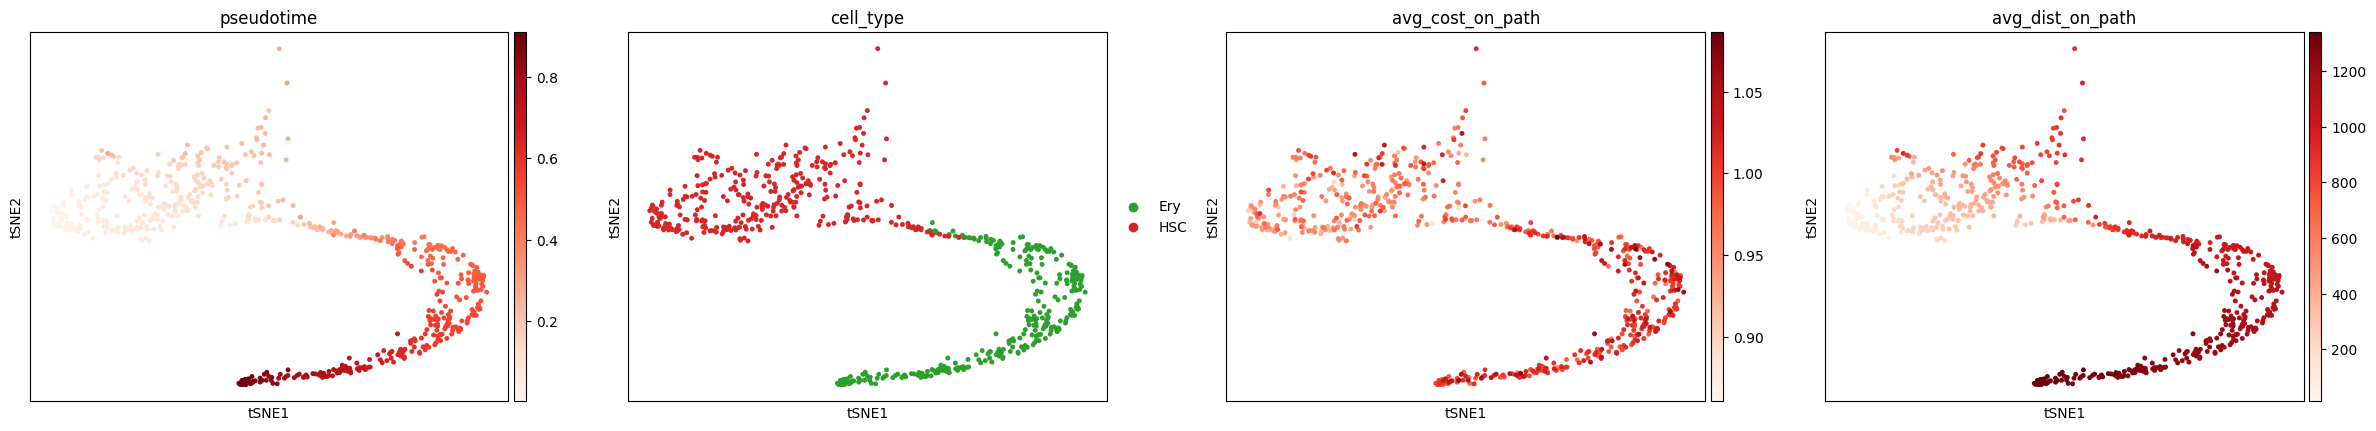

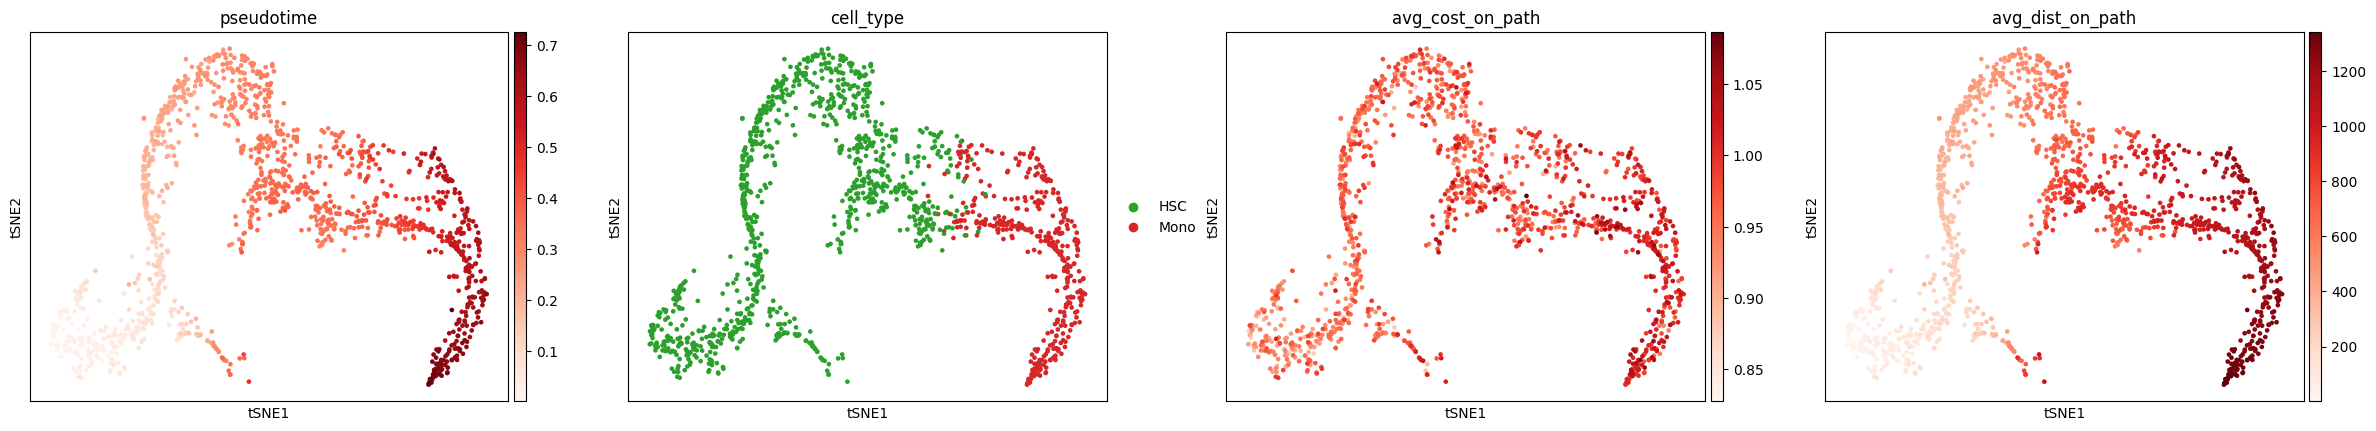

In [60]:
from matplotlib.colors import ListedColormap
from matplotlib import cm, pyplot as plt

sc.pl.tsne(dataset2, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 50)
sc.pl.tsne(dataset1, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 45)

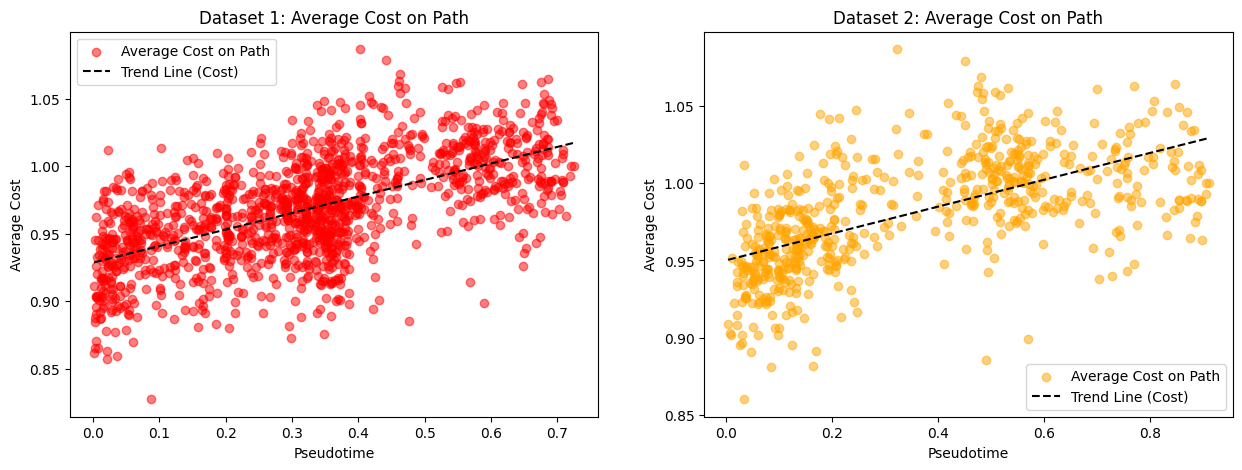

In [ ]:
# plot the average cost and distance on the path  sorted by pseudotime
import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = dataset1.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = dataset2.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

In [79]:
axes

array([<Axes: >, <Axes: >], dtype=object)

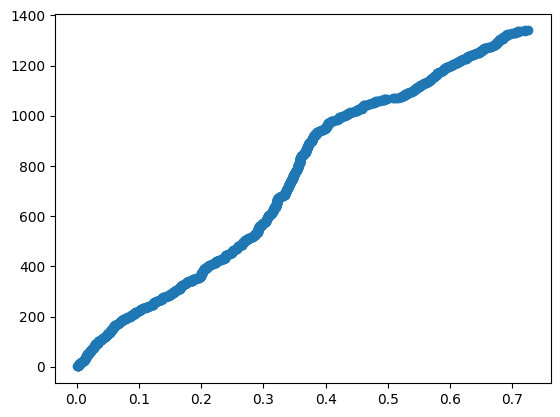

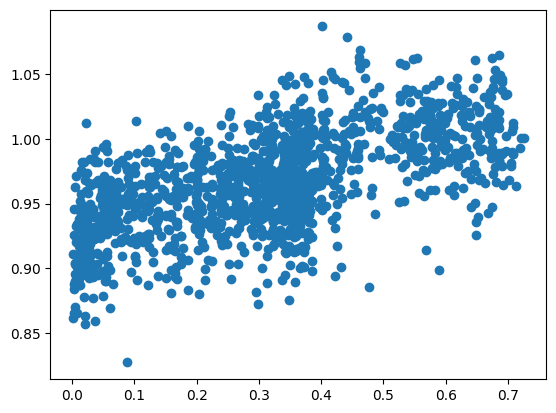

In [46]:
d1_pseudotime = dataset1.obs.sort_values("pseudotime")[["pseudotime"]].values
d2_pseudotime = dataset2.obs.sort_values("pseudotime")[["pseudotime"]].values

plt.scatter(d1_pseudotime, d1_avg_dist)
plt.show()
plt.scatter(d1_pseudotime, d1_avg_cost)

# Good alignment

In [7]:
d1_id = 15
d2_id = 20

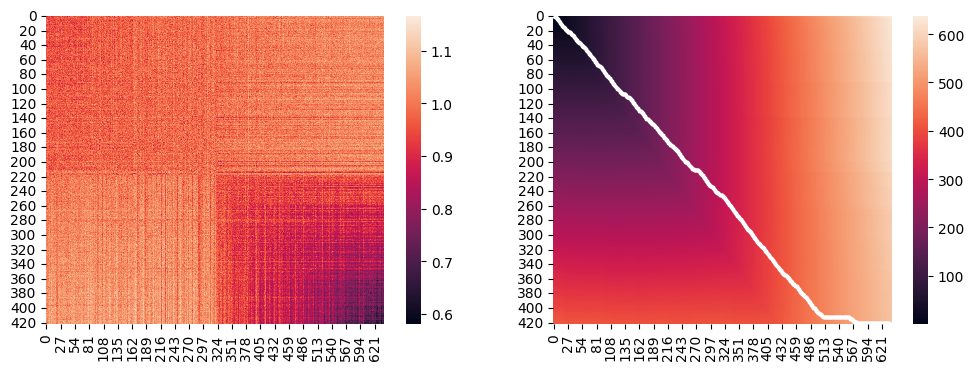

In [8]:
res2 = results_all_subsets[d1_id][d2_id][0]
res2.plot_cost_distances()

In [9]:
dataset1 = read_with_pc(f"data/rep{id_name[d1_id]['rep']}_{id_name[d1_id]['cell_type']}_subset{id_name[d1_id]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[d2_id]['rep']}_{id_name[d2_id]['cell_type']}_subset{id_name[d2_id]['subset']}_hvg.h5ad")

In [10]:
def skip_traceback_free2(D, i = None, j = None):
    # start from smallest value on the last row --> refers to j and q
    if i is None:
        i = D.shape[0] - 1
    if j is None:
        j = np.argmin(D[-1, :])
    print(i, j)

    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i - 1, j - 1], D[i, j - 1], D[i - 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            j -= 1
        elif tb == 2:
            i -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

In [11]:
dist1 = res2.distances()
path1, path2 = traceback_xedge(dist1[1:, 1:])

In [12]:
dist1

array([[  0.        ,          inf,          inf, ...,          inf,
                 inf,          inf],
       [         inf,   0.93204909,   1.84989919, ..., 635.97034444,
        637.00584562, 638.05608013],
       [         inf,   1.90035809,   1.87353343, ..., 635.89950625,
        636.94063753, 637.98944463],
       ...,
       [         inf, 415.77707971, 411.9370717 , ..., 566.42683323,
        567.09531759, 567.76284404],
       [         inf, 416.80495905, 412.96090591, ..., 565.59350192,
        566.25464083, 566.8922018 ],
       [         inf, 417.82815868, 414.01440939, ..., 565.56390971,
        566.2183799 , 566.88365396]], shape=(423, 641))

In [14]:
max(path1), max(path2), len(dataset1.obs_names), len(dataset2.obs_names), res2.cost().shape

(np.int64(421), np.int64(154), 422, 640, (422, 640))

In [15]:
costx, costy  = avg_cost_path(path1, path2, res2.cost(), dataset1, dataset2)
distx, disty = avg_cost_path(path1, path2, res2.distances(), dataset1, dataset2)

421 154 422 640 (422, 640)
421 154 422 640 (423, 641)


In [16]:
dataset1.obs["avg_cost_free"] = costx
dataset2.obs["avg_cost_free"] = costy
dataset1.obs["avg_dist_free"] = distx
dataset2.obs["avg_dist_free"] = disty

In [28]:
axes

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

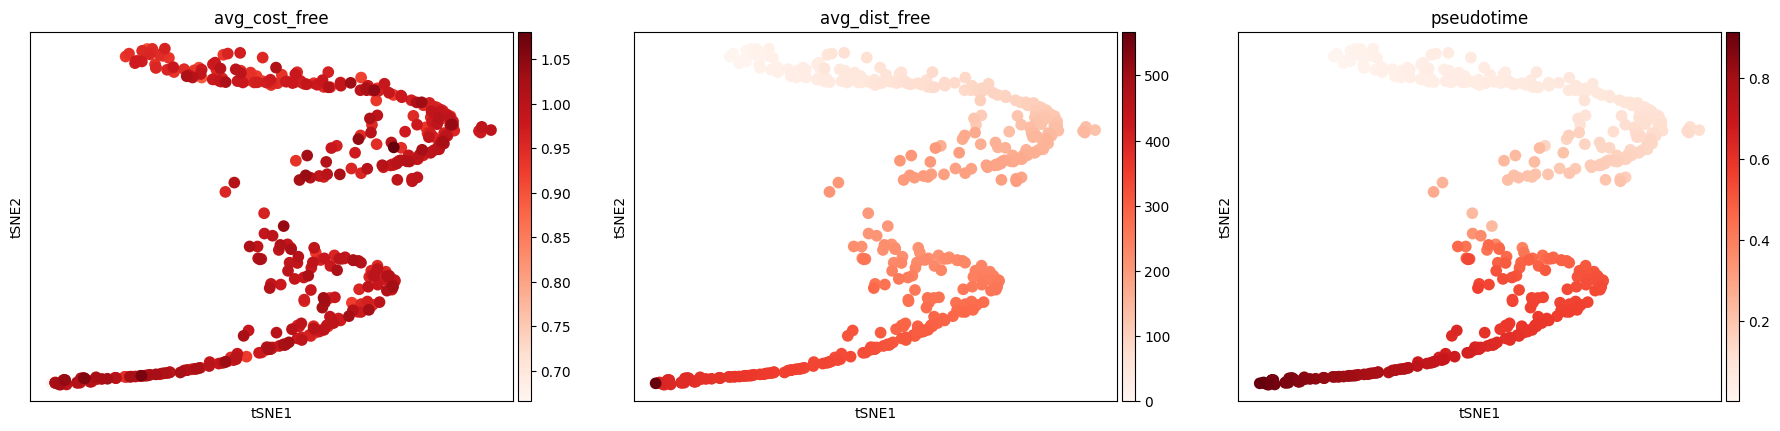

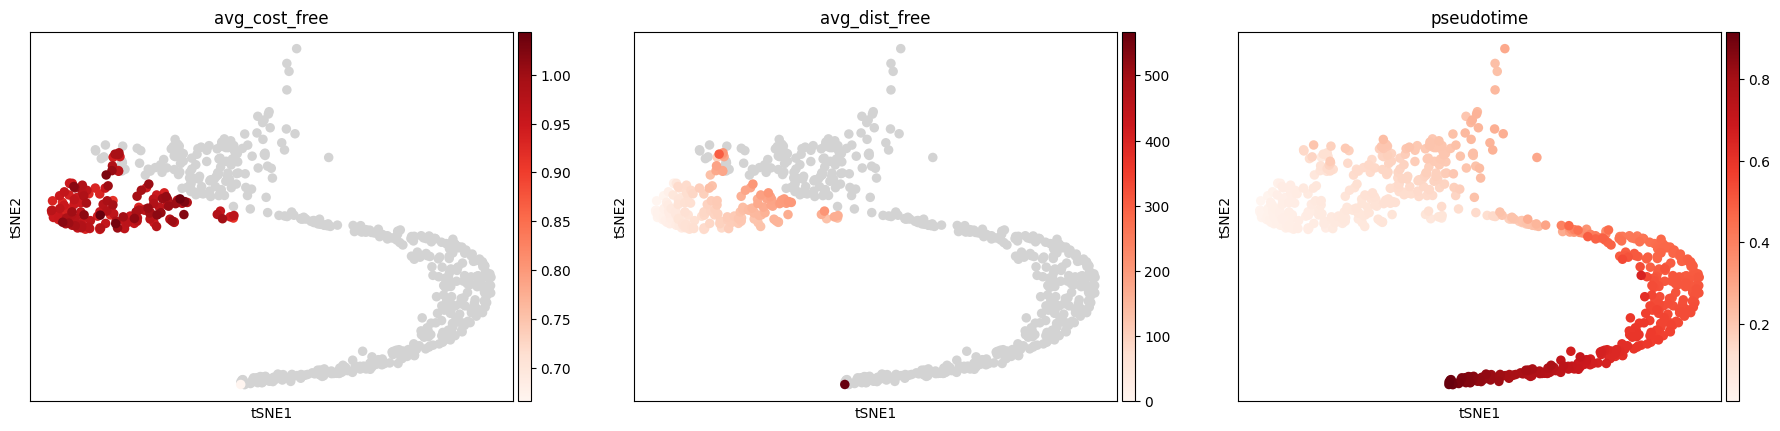

In [34]:
sc.pl.tsne(dataset1, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")
sc.pl.tsne(dataset2, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")

In [20]:
path1, path2 = traceback(res2.distances()[1:, 1:])

# path1 = res2.path1()
# path2 = res2.path2()

d1_res_dist = avg_cost_path(path2, path1, res2.distances()[1:, 1:], dataset2, dataset1)
d1_res_cost = avg_cost_path(path2, path1, res2.cost(), dataset2, dataset1)

dataset1.obs["avg_dist_on_path"] = d1_res_dist[1]
dataset2.obs["avg_dist_on_path"] = d1_res_dist[0]
dataset1.obs["avg_cost_on_path"] = d1_res_cost[1]
dataset2.obs["avg_cost_on_path"] = d1_res_cost[0]

639 421 640 422 (422, 640)
639 421 640 422 (422, 640)


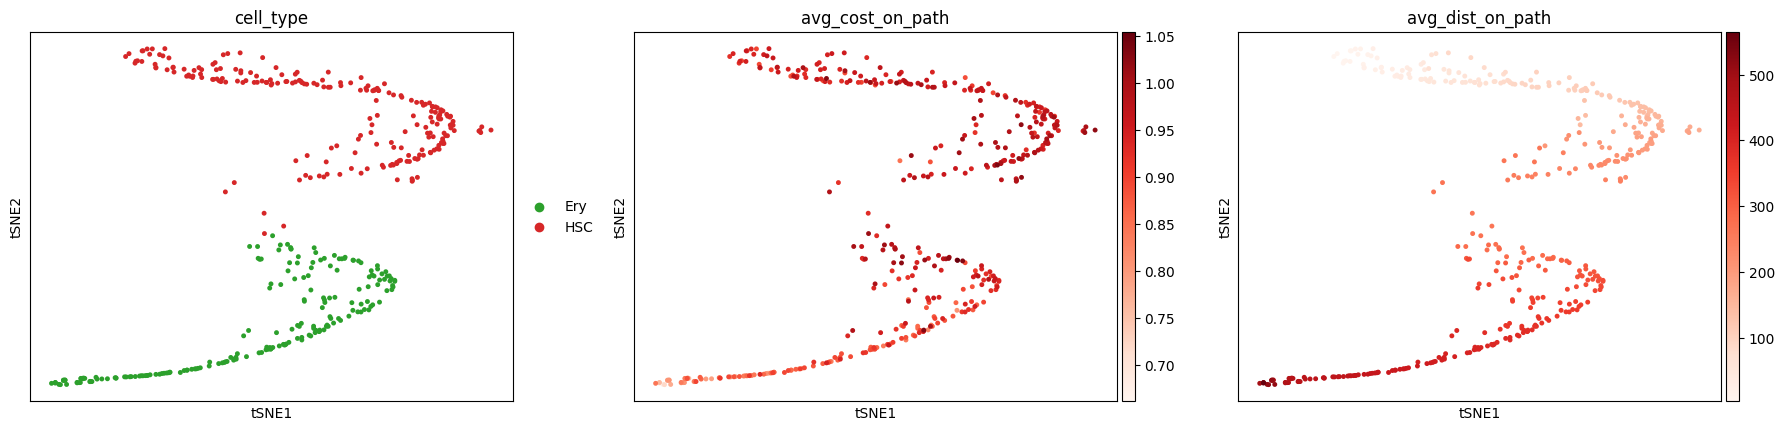

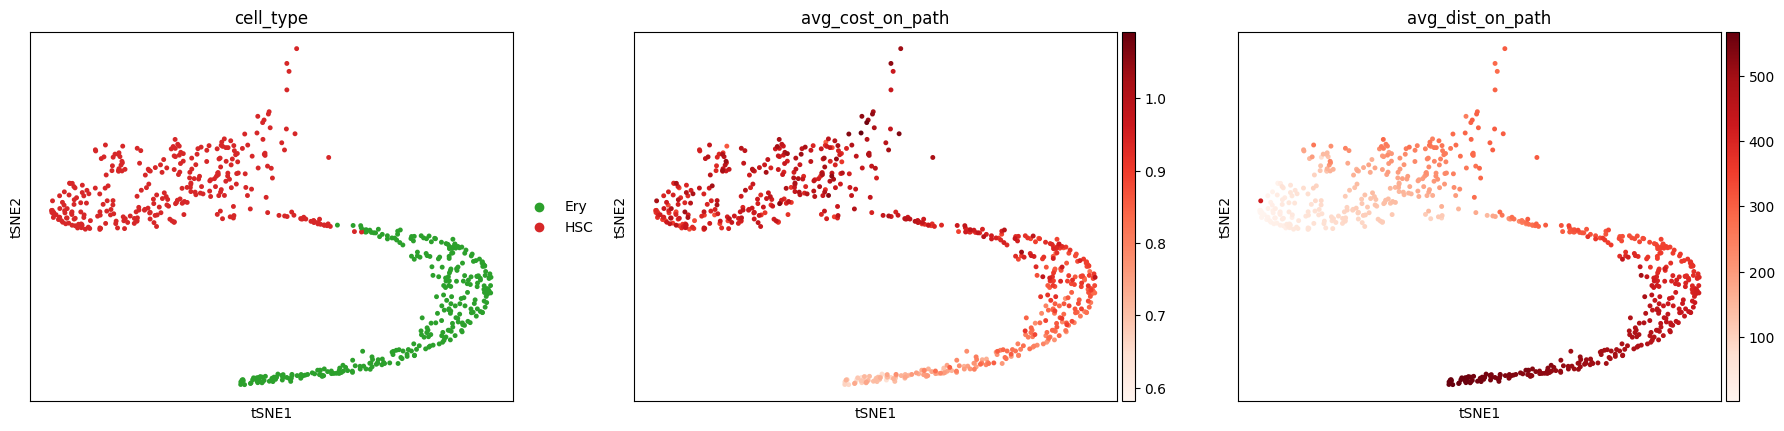

In [21]:
sc.pl.tsne(dataset1, color = ["cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 50)
sc.pl.tsne(dataset2, color = ["cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 50)

<Figure size 1000x500 with 0 Axes>

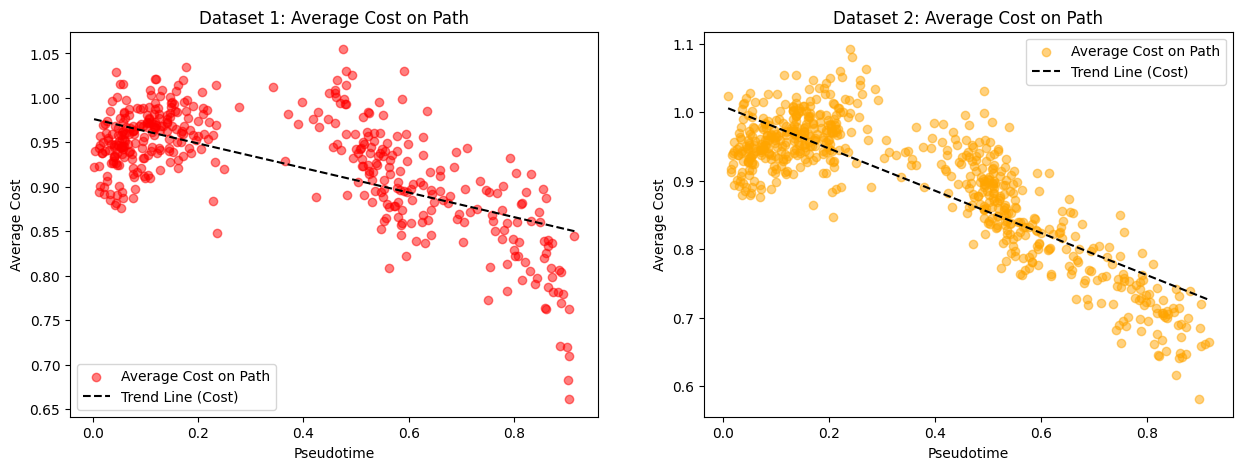

In [ ]:
# plot the average cost and distance on the path  sorted by pseudotime
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = dataset1.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = dataset2.obs.sort_values("pseudotime")["pseudotime"].values

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  